# Importing libraries

In [426]:
# !pip install quandl
# !pip install --upgrade --no-deps statsmodels
# !pip install pycaret
# !pip install kats
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U sklearn
# !pip install ta 
# !pip install -U pmdarima


In [427]:
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR, ARResults
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import random
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *
from kats.consts import TimeSeriesData
from pmdarima import auto_arima

In [428]:
pd.set_option('display.max_columns', None)

In [429]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"

# Data to be used 

In [430]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [431]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [432]:
# Test Data Start and end date
start_date = '2020-03-02'
end_date = '2021-03-23'

In [433]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = allSymbols):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [434]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
    print(result)
    out = pd.Series(result[0:4], index=label)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    print(out.to_string())
    if(result[1]<0.05):
        return ('Data is stationary')
    else:
        return 'Data is non-stationary'

# Time Series DataSet

In [435]:
dataset = pd.read_csv('TimeSeriesData.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [436]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

In [437]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges

code                                      StockName        Date  \
                                                                     min   
0   BOM500124        DR.REDDY'S LABORATORIES LTD. EOD Prices  2000-01-03   
1   BOM500180                       HDFC Bank Ltd EOD Prices  2000-01-03   
2   BOM500209                        INFOSYS LTD. EOD Prices  2000-01-03   
3   BOM500228                      JSW STEEL LTD. EOD Prices  2000-01-03   
4   BOM500247            KOTAK MAHINDRA BANK LTD. EOD Prices  2000-01-03   
5   BOM500440            HINDALCO INDUSTRIES LTD. EOD Prices  2000-01-03   
6   BOM500470                     TATA STEEL LTD. EOD Prices  2000-01-03   
7   BOM500570                    TATA MOTORS LTD. EOD Prices  2000-01-03   
8   BOM507685                          WIPRO LTD. EOD Prices  2000-01-03   
9   BOM524715  SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices  2000-01-03   
10  BOM532174                     ICICI BANK LTD. EOD Prices  2000-01-03   
11  BOM532488            DIVI'S LABORATORIES LTD. EOD Prices  2003-03-12   
12  BOM532500            MARUTI SUZUKI INDIA LTD. EOD Prices  2003-07-09   
13  BOM532540      TATA CONSULTANCY SERVICES LTD. EOD Prices  2004-08-25   
14  BOM532977                     BAJAJ AUTO LTD. EOD Prices  2008-05-26   
15     SENSEX                                     BSE SENSEX  2000-01-03   
16     SI0800                                 BSE Healthcare  2000-01-03   
17     SI1000                     BSE Information Technology  2000-01-03   
18     SI1200                                      BSE METAL  2000-01-03   
19     SI1900                                       BSE AUTO  2000-01-03   
20     SIBANK                                     BSE BANKEX  2002-01-01   

                
           max  
0   2021-03-23  
1   2021-03-23  
2   2021-03-23  
3   2021-03-23  
4   2021-03-23  
5   2021-03-23  
6   2021-03-23  
7   2021-03-23  
8   2021-03-23  
9   2021-03-23  
10  2021-03-23  
11  2021-03-23  
12  2021-03-23  
13  2021-03-23  
14  2021-03-23  
15  2021-03-23  
16  2021-03-23  
17  2021-03-23  
18  2021-03-23  
19  2021-03-23  
20  2021-03-23

In [438]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges.code==stockCode, 'StockName'].values[0];

In [439]:
data = dataset.set_index('Date')
data.head()
len(data)

105449

# Populate dictionary to hold individual Stock Data

In [440]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]


In [441]:
len(allSymbols)

21

In [442]:
ScriptWiseData

{'BOM500124':                Open     High      Low    Close          WAP  No. of Shares  \
 Date                                                                         
 2000-01-03  1500.00  1557.35  1500.00  1557.35  1544.195154        82330.0   
 2000-01-04  1601.00  1681.00  1527.00  1647.25  1621.040930       210676.0   
 2000-01-05  1600.00  1648.00  1515.50  1559.00  1590.903923       205669.0   
 2000-01-06  1582.00  1683.70  1560.00  1683.70  1623.244182       161085.0   
 2000-01-07  1718.00  1718.00  1549.05  1549.05  1593.853264       120952.0   
 ...             ...      ...      ...      ...          ...            ...   
 2021-03-17  4448.85  4465.00  4343.20  4356.85  4397.460000        16839.0   
 2021-03-18  4388.00  4388.00  4200.00  4211.30  4265.490000        46984.0   
 2021-03-19  4220.00  4303.85  4135.90  4274.55  4218.990000        49415.0   
 2021-03-22  4288.00  4366.45  4271.90  4353.90  4336.430000        49256.0   
 2021-03-23  4351.00  4403.50  4322.80 

# View null values in the data

In [443]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282


# Deriving Technical indicators

### MACD

In [444]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [445]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [446]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [447]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

## ATR

In [448]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [449]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

## Bollinger band

In [450]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [451]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

## OBV

In [452]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [453]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

## ADX

In [454]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [455]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

# Removing Extra Columms

In [456]:
allSymbols

['BOM524715',
 'BOM532488',
 'BOM500124',
 'BOM500180',
 'BOM532174',
 'BOM500247',
 'BOM500470',
 'BOM500228',
 'BOM500440',
 'BOM532977',
 'BOM500570',
 'BOM532500',
 'BOM500209',
 'BOM532540',
 'BOM507685',
 'SI0800',
 'SI1000',
 'SIBANK',
 'SI1200',
 'SI1900',
 'SENSEX']

In [457]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

In [458]:
ScriptWiseData

{'BOM500124':               Close       RSI       ATR        MACD        adx         OBV
 Date                                                                      
 2000-01-03  1557.35       NaN       NaN         NaN   0.000000         0.0
 2000-01-04  1647.25       NaN       NaN         NaN   0.000000    210676.0
 2000-01-05  1559.00       NaN       NaN         NaN   0.000000      5007.0
 2000-01-06  1683.70       NaN       NaN         NaN   0.000000    166092.0
 2000-01-07  1549.05       NaN       NaN         NaN   0.000000     45140.0
 ...             ...       ...       ...         ...        ...         ...
 2021-03-17  4356.85  0.631562  139.4350  -96.256191  35.594600  25808594.0
 2021-03-18  4211.30  0.503642  142.6300 -108.287499  37.310951  25761610.0
 2021-03-19  4274.55  0.597947  146.0275 -111.434108  39.153291  25811025.0
 2021-03-22  4353.90  0.724707  141.0075 -106.299581  39.895697  25860281.0
 2021-03-23  4371.95  0.755601  127.7925  -99.625526  40.047647  25887462.0

In [459]:

# for symbol in allSymbols:
#     print(ScriptWiseData[symbol])
ScriptWiseData['BOM532540']

,Close,RSI,ATR,MACD,adx,OBV
Date,,,,,,
2004-08-25,987.50,NaN,NaN,NaN,0.000000,0.0
2004-08-26,978.55,NaN,NaN,NaN,0.000000,-2243016.0
2004-08-27,962.35,NaN,NaN,NaN,0.000000,-3746333.0
2004-08-30,986.25,NaN,NaN,NaN,0.000000,-2621514.0
2004-08-31,987.95,NaN,NaN,NaN,0.000000,-1486448.0
...,...,...,...,...,...,...
2021-03-17,3112.70,1.239575,86.1700,-2.973397,26.936046,52533504.0
2021-03-18,3036.80,0.903269,89.8575,-4.630507,26.565250,52439401.0
2021-03-19,3063.25,1.004569,91.1975,-3.766072,26.220940,52641475.0


## Dropping null values

In [460]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

# ARIMAX for Stock "BOM532540" - TCS

In [461]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from math import sqrt
from scipy.stats.distributions import chi2

In [462]:
Stock = 'BOM532540'
ScriptWiseData[Stock]

,Close,RSI,ATR,MACD,adx,OBV
Date,,,,,,
2004-10-01,1048.25,1.781982,17.4850,8.086665,27.865725,485611.0
2004-10-04,1076.80,2.653364,18.5375,11.022214,29.406966,1101096.0
2004-10-05,1080.20,2.764549,18.9275,13.432900,31.082611,1861397.0
2004-10-06,1081.15,2.797834,19.8775,15.229562,33.012967,2677803.0
2004-10-07,1096.75,3.383456,19.8075,17.605517,34.805440,3134018.0
...,...,...,...,...,...,...
2021-03-17,3112.70,1.239575,86.1700,-2.973397,26.936046,52533504.0
2021-03-18,3036.80,0.903269,89.8575,-4.630507,26.565250,52439401.0
2021-03-19,3063.25,1.004569,91.1975,-3.766072,26.220940,52641475.0


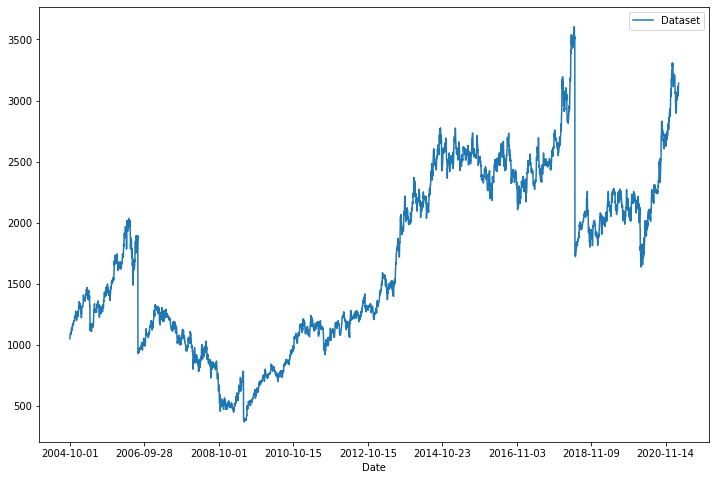

In [463]:
ScriptWiseData[Stock].Close.plot(legend=True, label = 'Dataset', figsize = (12,8))

In [464]:
print(adf_test(ScriptWiseData[Stock].Close, title='ADF Test for Stock market prices'))

(-1.5359616449792204, 0.5156526027756796, 0, 4087, {'1%': -3.4319510305663132, '5%': -2.8622474476057733, '10%': -2.567146581184536}, 42215.16125378273)
ADF test statistic        -1.535962
p-value                    0.515653
# lags used                0.000000
#observations           4087.000000
critical value (1%)       -3.431951
critical value (5%)       -2.862247
critical value (10%)      -2.567147
Data is non-stationary



### The ACF





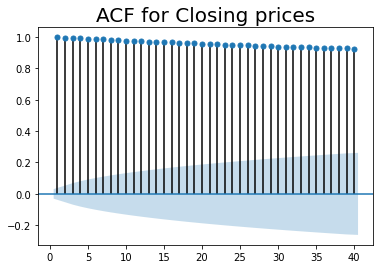

In [465]:
sgt.plot_acf(ScriptWiseData[Stock].Close, zero= False, lags = 40);
plt.title("ACF for Closing prices", size = 20)
plt.show()

### The PACF



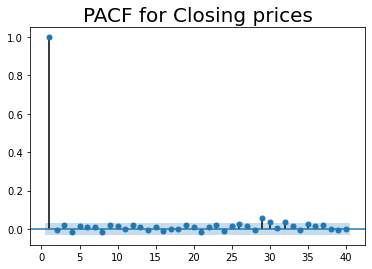

In [466]:
sgt.plot_pacf(ScriptWiseData[Stock].Close, alpha= 0.05, zero= False, lags = 40, method=('ols'));
plt.title("PACF for Closing prices", size = 20)
plt.show()

### Common functions

In [467]:
test_start_date = '2020-03-02'
test_end_date = '2021-03-23'
actual = ScriptWiseData[Stock].Close.loc[test_start_date:test_end_date]
len(actual)

265

In [468]:
def LLRTest(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  LR = (2*(L2-L1))
  P = chi2.sf(LR, DF).round(3)
  return P


In [469]:
def plot_acf(data, title = ''):
  sgt.plot_acf(data, lags = 40, zero = False)
  plt.title(title, size=24)
  plt.show()

def plot_pacf(data, title = ''):
  sgt.plot_pacf(data, lags = 40, zero = False, method= ('ols'))
  plt.title(title, size=24)
  plt.show()

In [470]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

In [471]:
def errorEvaluation(actual, pred):
  print("RMSE: " + str(mean_squared_error(actual, pred, squared=False)))
  print("MAPE: " + str(mean_absolute_percentage_error(actual,pred)))
  print("R2 Score: " + str(r2_score(actual,pred)))

In [472]:
# Modified Prediction O/P
def modified_prediction_frame(_df_pred, index):
  _df_pred = _df_pred.to_frame()
  _df_pred['Date'] = index
  pd.to_datetime(_df_pred['Date'])
  _df_pred.set_index('Date', inplace=True)
  _df_pred.rename(columns={0 : 'Predicted'}, inplace=True)
  return _df_pred


### The AR(1) model



In [473]:
df = ScriptWiseData[Stock]
df.head()

,Close,RSI,ATR,MACD,adx,OBV
Date,,,,,,
2004-10-01,1048.25,1.781982,17.4850,8.086665,27.865725,485611.0
2004-10-04,1076.80,2.653364,18.5375,11.022214,29.406966,1101096.0
2004-10-05,1080.20,2.764549,18.9275,13.432900,31.082611,1861397.0
2004-10-06,1081.15,2.797834,19.8775,15.229562,33.012967,2677803.0
2004-10-07,1096.75,3.383456,19.8075,17.605517,34.805440,3134018.0


In [474]:
adf_test(df.Close)

(-1.5359616449792204, 0.5156526027756796, 0, 4087, {'1%': -3.4319510305663132, '5%': -2.8622474476057733, '10%': -2.567146581184536}, 42215.16125378273)
ADF test statistic        -1.535962
p-value                    0.515653
# lags used                0.000000
#observations           4087.000000
critical value (1%)       -3.431951
critical value (5%)       -2.862247
critical value (10%)      -2.567147


'Data is non-stationary'

In [475]:
train_data, test_data = TrainTestSplitByDateRange(df.Close)

start = len(train_data)
end = len(train_data) + len(test_data) - 1

test_start_date = '2020-03-02'
test_end_date = '2021-03-23'

index = test_data.index

In [476]:
# model_ar = ARMA(ScriptWiseData[Stock].Close, order = (1,0))
# result_ar = model_ar.fit()
# df_pred = result_ar.predict(start = test_start_date, end = test_end_date)
# print(result_ar.summary())
#-------------------------------------------------------------------------------------With Train data

AR_Model = AR(train_data)
result_ar = AR_Model.fit(maxlag=1)
print(result_ar.params)
predictions1 = result_ar.predict(start = start, end = end)


const       3.512901
L1.Close    0.998006
dtype: float64


In [477]:
predictions1 = modified_prediction_frame(predictions1,index)
predictions1.head()

,Predicted
Date,
2020-03-03,1999.424572
2020-03-04,1998.950092
2020-03-05,1998.476558
2020-03-06,1998.003968
2020-03-09,1997.532321


In [478]:
print(result_ar.summary())
errorEvaluation(test_data,predictions1)

                               AR Model Results                               
Dep. Variable:                      C  -                  l                  o
Model:                          AR(1)   Log Likelihood              -19852.003
Method:                          cmle   S.D. of innovations             43.547
Date:                Fri, 16 Jul 2021   AIC                              7.549
Time:                        12:12:59   BIC                              7.554
Sample:                             0   HQIC                             7.551
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5129      1.791      1.961      0.050       0.002       7.024
L1.Close       0.9980      0.001    991.665      0.000       0.996       1.000
                                    Roots           

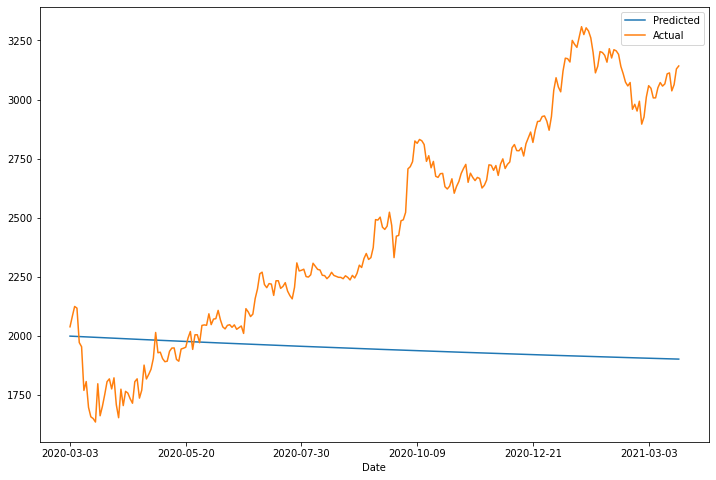

In [479]:
df_pred.plot(legend=True, label = 'Predicted', figsize = (12,8))
test_data.plot(legend=True, label = 'Actual', figsize = (12,8))

### Higher-Lag AR Models





> With Lag 2



In [480]:
AR2_Model = AR(train_data)
result_ar_2 = AR2_Model.fit(maxlag=2)
predictions2 = result_ar_2.predict(start = start, end = end)
print(result_ar_2.summary())


                               AR Model Results                               
Dep. Variable:                      C  -                  l                  o
Model:                          AR(2)   Log Likelihood              -19846.796
Method:                          cmle   S.D. of innovations             43.547
Date:                Fri, 16 Jul 2021   AIC                              7.550
Time:                        12:13:00   BIC                              7.556
Sample:                             0   HQIC                             7.552
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5284      1.793      1.968      0.049       0.015       7.042
L1.Close       1.0109      0.016     62.481      0.000       0.979       1.043
L2.Close      -0.0129      0.016     -0.799      0.4

In [481]:
predictions2 = modified_prediction_frame(predictions2,index)

In [482]:
print(test_data.describe())
print('---------------')
print(errorEvaluation(test_data,predictions2))

count     264.000000
mean     2459.927273
std       468.554923
min      1636.100000
25%      2047.575000
50%      2361.325000
75%      2827.037500
max      3308.200000
Name: Close, dtype: float64
---------------
RMSE: 715.4270572492364
MAPE: 0.21122817591924914
R2 Score: -1.3402264790435923
None


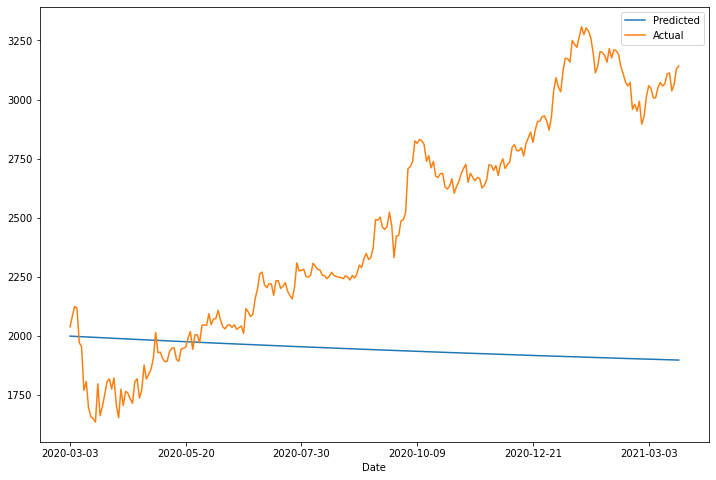

In [483]:
predictions2.plot(legend=True, label = 'Predicted', figsize = (12,8))
test_data.plot(legend=True, label = 'Actual', figsize = (12,8))



> Auto Predict Lag



In [484]:
AR_M = AR(train_data)
result_ar = AR_M.fit(ic = 't-stat')

In [485]:
result_ar.params

const        2.722153
L1.Close     1.008916
L2.Close    -0.032333
L3.Close     0.032269
L4.Close    -0.033983
L5.Close     0.006809
L6.Close     0.013095
L7.Close     0.014249
L8.Close    -0.029162
L9.Close     0.004398
L10.Close    0.010860
L11.Close   -0.014438
L12.Close   -0.006409
L13.Close    0.027428
L14.Close   -0.014620
L15.Close    0.018233
L16.Close   -0.015480
L17.Close    0.000460
L18.Close   -0.007225
L19.Close    0.001143
L20.Close    0.024867
L21.Close   -0.021900
L22.Close   -0.017518
L23.Close    0.041515
L24.Close   -0.024759
L25.Close   -0.018369
L26.Close    0.016156
L27.Close    0.015116
L28.Close   -0.058979
L29.Close    0.020257
L30.Close    0.037930
dtype: float64



```
# According to the predictions, a lag of 30 is recommended however we have seen it is not possible to predict a non linear data with the AR model.
```



# Using Returns

In [486]:
df

,Close,RSI,ATR,MACD,adx,OBV
Date,,,,,,
2004-10-01,1048.25,1.781982,17.4850,8.086665,27.865725,485611.0
2004-10-04,1076.80,2.653364,18.5375,11.022214,29.406966,1101096.0
2004-10-05,1080.20,2.764549,18.9275,13.432900,31.082611,1861397.0
2004-10-06,1081.15,2.797834,19.8775,15.229562,33.012967,2677803.0
2004-10-07,1096.75,3.383456,19.8075,17.605517,34.805440,3134018.0
...,...,...,...,...,...,...
2021-03-17,3112.70,1.239575,86.1700,-2.973397,26.936046,52533504.0
2021-03-18,3036.80,0.903269,89.8575,-4.630507,26.565250,52439401.0
2021-03-19,3063.25,1.004569,91.1975,-3.766072,26.220940,52641475.0


In [487]:
df['Stock_Returns'] = df.Close.pct_change(1).mul(100)
df = df[1:]

In [488]:
df.head()

,Close,RSI,ATR,MACD,adx,OBV,Stock_Returns
Date,,,,,,,
2004-10-04,1076.80,2.653364,18.5375,11.022214,29.406966,1101096.0,2.723587
2004-10-05,1080.20,2.764549,18.9275,13.432900,31.082611,1861397.0,0.315750
2004-10-06,1081.15,2.797834,19.8775,15.229562,33.012967,2677803.0,0.087947
2004-10-07,1096.75,3.383456,19.8075,17.605517,34.805440,3134018.0,1.442908
2004-10-08,1097.80,3.425688,20.1075,19.336971,36.735526,3590849.0,0.095737




> ADF Test on returns



In [489]:
print(adf_test(df['Stock_Returns'], title='ADF Test for Stock market Returns'))

(-14.15125563805675, 2.1598919973094363e-26, 31, 4055, {'1%': -3.4319636730977967, '5%': -2.862253032448362, '10%': -2.567149554309502}, 18493.250093531162)
ADF test statistic     -1.415126e+01
p-value                 2.159892e-26
# lags used             3.100000e+01
#observations           4.055000e+03
critical value (1%)    -3.431964e+00
critical value (5%)    -2.862253e+00
critical value (10%)   -2.567150e+00
Data is stationary


### ACF and PACF for Returns

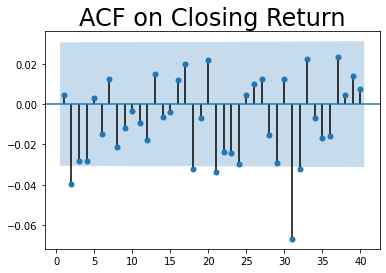

In [490]:
plot_acf(df['Stock_Returns'], 'ACF on Closing Return')

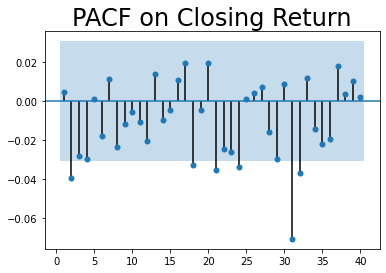

In [491]:
plot_pacf(df['Stock_Returns'], 'PACF on Closing Return')

### AR(1) model for returns

In [492]:
df['Stock_Returns'].describe()

count    4087.000000
mean        0.059877
std         2.362673
min       -50.981169
25%        -0.881477
50%         0.072126
75%         1.037957
max        15.336716
Name: Stock_Returns, dtype: float64

In [493]:
train_returns_data, test_returns_data = TrainTestSplitByDateRange(df.Stock_Returns)

start = len(train_returns_data)
end = len(train_returns_data) + len(test_returns_data) - 1

test_start_date = '2020-03-02'
test_end_date = '2021-03-23'

index = test_returns_data.index

In [494]:
test_returns_data.head()

Date
2020-03-03    1.950098
2020-03-04    2.170288
2020-03-05    2.004176
2020-03-06   -0.329427
2020-03-09   -6.879456
Name: Stock_Returns, dtype: float64

In [495]:
AR_Model_returns = AR(train_returns_data)
result_ar_returns = AR_Model_returns.fit(maxlag=1)
print(result_ar_returns.params)
predictions_returns_1 = result_ar_returns.predict(start = start, end = end)

const               0.049095
L1.Stock_Returns    0.014347
dtype: float64


In [496]:
predictions_returns_1.head()

3823    0.048342
3824    0.049788
3825    0.049809
3826    0.049809
3827    0.049809
dtype: float64

In [497]:
predictions_returns_1 = modified_prediction_frame(predictions_returns_1,index)

In [498]:
predictions_returns_1.head()

,Predicted
Date,
2020-03-03,0.048342
2020-03-04,0.049788
2020-03-05,0.049809
2020-03-06,0.049809
2020-03-09,0.049809


In [499]:
print(result_ar_returns.summary())
errorEvaluation(test_returns_data,predictions_returns_1)

                               AR Model Results                               
Dep. Variable:                      S  -                  t                  o
Model:                          AR(1)   Log Likelihood               -8725.810
Method:                          cmle   S.D. of innovations              2.373
Date:                Fri, 16 Jul 2021   AIC                              1.730
Time:                        12:13:01   BIC                              1.735
Sample:                             0   HQIC                             1.732
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0491      0.038      1.278      0.201      -0.026       0.124
L1.Stock_Returns     0.0143      0.016      0.887      0.375      -0.017       0.046
                            

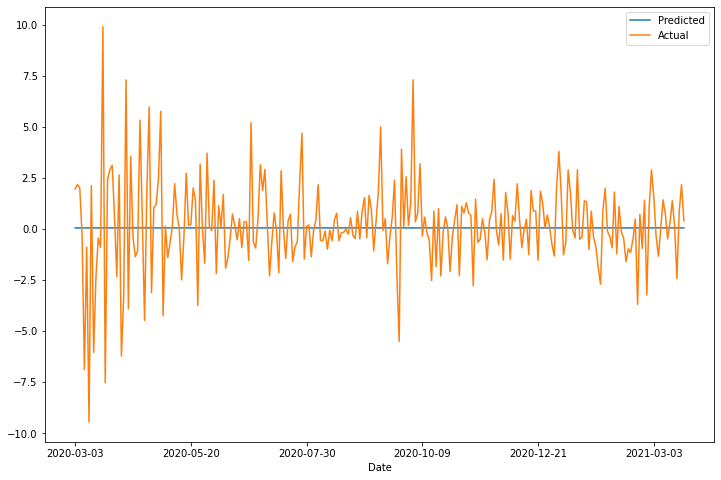

In [354]:
predictions_returns_1.plot(legend=True, label = 'Predicted', figsize = (12,8))
test_returns_data.plot(legend=True, label = 'Actual', figsize = (12,8))

# Normalizing values and returns

In [ ]:
benchmark_prices = df.Close.iloc[0]
Normalized_prices = df.Close.div(benchmark_prices).mul(100)

#actual_returns_normal = Normalized_prices.loc[test_start_date:test_end_date]
print(benchmark_prices)
print(Normalized_prices)
df['Normal_Prices'] = Normalized_prices
df.head()


In [358]:
adf_test(Normalized_prices)

(-1.5270429236733392, 0.5200937126225964, 0, 4086, {'1%': -3.4319514226461165, '5%': -2.862247620807516, '10%': -2.567146673389478}, 22931.364080142004)
ADF test statistic        -1.527043
p-value                    0.520094
# lags used                0.000000
#observations           4086.000000
critical value (1%)       -3.431951
critical value (5%)       -2.862248
critical value (10%)      -2.567147


'Data is non-stationary'

In [87]:
model_ar_normal_1 = ARMA(Normalized_prices, order = (1,0))
result_ar_normal_1 = model_ar_normal_1.fit()
df_pred_normal_1 = result_ar_normal_1.predict(start = test_start_date, end = test_end_date)
print(result_ar_normal_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4088
Model:                     ARMA(1, 0)   Log Likelihood              -11655.208
Method:                       css-mle   S.D. of innovations              4.185
Date:                Fri, 16 Jul 2021   AIC                          23316.416
Time:                        08:35:51   BIC                          23335.364
Sample:                             0   HQIC                         23323.125
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         170.3193     36.565      4.658      0.000      98.654     241.984
ar.L1.Close     0.9984      0.001   1136.775      0.000       0.997       1.000
                                    Roots       

In [83]:
errorEvaluation(actual_returns_normal, df_pred_normal_1)

RMSE: 4.5937907915815
MAPE: 0.01506300847118482
R2 Score: 0.9893962757102988


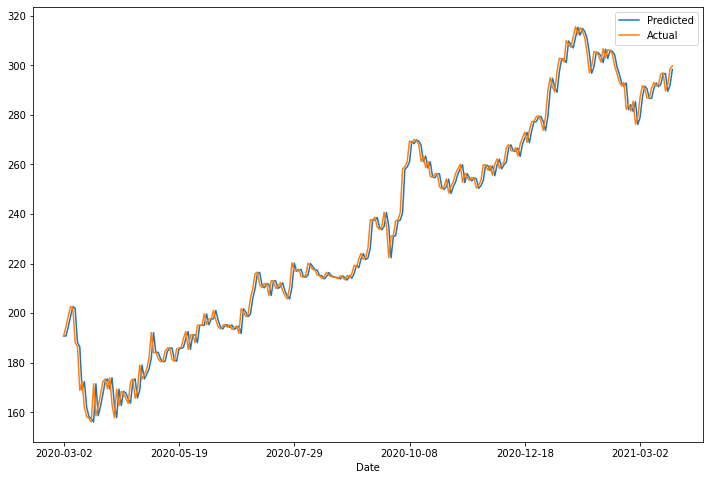

In [78]:
# df_pred_normal_1.plot(figsize = (12,8))
# actual_returns_normal.plot(figsize = (12,8))
df_pred_normal_1.plot(legend=True, label = 'Predicted', figsize = (12,8))
actual_returns_normal.plot(legend=True, label = 'Actual', figsize = (12,8))

In [88]:
model_ar_normal_8 = ARMA(Normalized_prices, order = (8,0))
result_ar_normal_8 = model_ar_normal_8.fit()
df_pred_normal_8 = result_ar_normal_8.predict(start = test_start_date, end = test_end_date)
#print(result_ar_normal_8.summary())

In [90]:
errorEvaluation(actual_returns_normal, df_pred_normal_8)

RMSE: 4.592630901466173
MAPE: 0.015018818168997876
R2 Score: 0.9894016297208905


### Auto Arima Functionality

In [165]:
stepwise_fit = auto_arima(ScriptWiseData[Stock].Close, start_p=0, start_q=0, max_p=6, max_q = 3, seasonal= False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46263.458, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46265.446, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46265.447, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46261.460, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46267.447, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.311 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4708
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -23129.730
Date:                Wed, 14 Jul 2021   AIC                          46261.460
Time:                        12:03:53   BIC                          46267.917
Sample:                             0   HQIC                         46263.730
                               - 4708                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1085.4085      0.711   1526.979      0.000    1084.015    1086.802
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         768804220.46
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                           -37.00
Prob(H) (two-sided):                  0.00   Kurtosis:                      1981.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
stepwise_fit_ = auto_arima(ScriptWiseData[Stock].Close, start_p=0, start_q=0, max_p=4, max_q = 4, seasonal= True, trace=True,m=12)
stepwise_fit_.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=46263.922, Time=6.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=46263.458, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=46266.431, Time=1.75 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=46266.393, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46261.460, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=46264.446, Time=1.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=46264.406, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=46265.446, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=46265.447, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=46267.447, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 12.531 seconds


(0, 1, 0)

# Amit Sir Code

In [91]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

In [ ]:
train, test = TrainTestSplitByDateRange(ScriptWiseData[Stock])
len(train)
test

In [ ]:
AutoArimaResults = pd.DataFrame(columns=['p', 'd', 'q'], index = stocks)
AutoArimaResults

In [96]:
def CalculateAutoArima(stockcode, data):
    if(AutoArimaResults.isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data['Close'], maxiter = 1000)
        AutoArimaResults.loc[stockcode, ['p', 'd', 'q']] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, ['p', 'd', 'q']])

In [111]:
# def ARIMAXProcedure(stockCode):
#     dataSet = ScriptWiseData[stockCode]
#     train, test = TrainTestSplitByDateRange(dataSet)
#     ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order = CalculateAutoArima(stockCode, dataSet))
#     ARIMAXModel = ARIMAXModel.fit()
#     df_pred = ARIMAXModel.predict(start = start_date, end = end_date, exog = test[TechnicalIndicators])
#     return ARIMAXModel, df_pred
def ARIMAXProcedure(stockCode):
    dataSet = ScriptWiseData[stockCode]
    train, test = TrainTestSplitByDateRange(dataSet)
    ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order = CalculateAutoArima(stockCode, dataSet))
    ARIMAXModel = ARIMAXModel.fit()
    df_pred = ARIMAXModel.predict(start = start_date, end = end_date, exog = test[TechnicalIndicators])
    return ARIMAXModel, df_pred

In [112]:
model, pred = ARIMAXProcedure(Stock)

In [116]:
actual = test.Close
print(actual)

Date
2020-03-03    393.35
2020-03-04    405.70
2020-03-05    404.85
2020-03-06    400.90
2020-03-09    394.95
2020-03-11    386.30
2020-03-12    354.85
2020-03-13    384.45
2020-03-16    368.80
2020-03-17    370.55
2020-03-18    362.50
2020-03-19    360.20
2020-03-20    365.80
2020-03-23    324.00
2020-03-24    335.05
2020-03-25    347.05
2020-03-26    338.55
2020-03-27    338.15
2020-03-30    333.65
2020-03-31    352.20
2020-04-01    343.55
2020-04-03    375.90
2020-04-07    417.10
2020-04-08    436.65
2020-04-09    455.20
2020-04-13    462.10
2020-04-15    448.95
2020-04-16    464.10
2020-04-17    457.00
2020-04-20    473.40
2020-04-21    471.95
2020-04-22    474.25
2020-04-23    477.30
2020-04-24    485.25
2020-04-27    489.80
2020-04-28    473.80
2020-04-29    477.85
2020-04-30    464.85
2020-05-04    465.05
2020-05-05    456.35
2020-05-06    454.55
2020-05-07    452.30
2020-05-08    469.00
2020-05-11    463.25
2020-05-12    463.85
2020-05-13    452.40
2020-05-14    455.95
2020-05-

In [120]:
pred = pred[1:]

In [121]:
# print(model)
 
print(sqrt(mean_squared_error(actual, pred)))

514.7695791489982
